# 1. Library Import

In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

import xgboost as xgb
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error, roc_auc_score


# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)


def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = '/kaggle/input/dacon-lg/'

# 2. 학습데이터 생성

In [35]:
train_err = pd.read_csv(PATH + "train_err_data.csv")
train_qual = pd.read_csv(PATH + "train_quality_data.csv")
train_prb = pd.read_csv(PATH + "train_problem_data.csv")
#test_err = pd.read_csv(PATH + "test_err_data.csv")
#test_qual = pd.read_csv(PATH + "test_quality_data.csv")
#sample_submission = pd.read_csv(PATH + "sample_submission.csv")

### Train_err 데이터 전처리

In [36]:
#err = pd.concat([train_err, test_err], axis=0).drop_duplicates()
#err
#train_err
train_err = train_err.drop_duplicates()

In [37]:
# 컬럼 정제

def make_col(input_data) :
    input_data["time"] = input_data.time.apply(lambda x : make_datetime(x))
    
    # 월 생성 코드
    input_data['month'] = input_data.time.dt.month

    # 일 생성 코드
    input_data['days'] = input_data.time.dt.day

    # 요일 생성 코드
    input_data['dayofweek'] = input_data.time.dt.dayofweek

    # 시간 생성 코드
    input_data["hour"] = input_data.time.dt.hour

    # 주말/평일 여부 생성코드
    weekend_dic = {5:1, 6:1 , 0:0, 1:0, 2:0, 3:0, 4:0}
    input_data["weekend_day"] = input_data.dayofweek.map(weekend_dic)

    # 오전/오후 생성 코드 -> 오전일 경우 0, 오후일 경우 1
    input_data["ampm"] = input_data.hour.apply(lambda x : 0 if x<12 else 1)

    # 날짜-최초데이터날짜 생성 코드
    min_day = input_data.time.min().date()
    input_data['mdays'] = input_data.time.dt.date - min_day
    input_data['mdays'] = input_data['mdays'].dt.days
    
    
    """## 에러코드 변수 정리
    # 상위 3개 밸류 -> 0 , 나머지 밸류들 -> 1로 표현

    input_data["is_freq_err_code"] = input_data.errcode.apply(lambda x : 0 if str(x) in ["1", "0", "connection timeout"] else 1)
    input_data["is_freq_err_code"].value_counts()

    # 상위 3개 밸류와 나머지 여러 밸류를 총 4개의 변수로 표현

    input_data["int_errcode"] = input_data.errcode.apply(lambda x : 0 if str(x) == "0" else (1 if str(x) =="1" else (2 if x == 'connection timeout' else 3)))
    input_data["int_errcode"].value_counts()"""
    
    return input_data




In [38]:
make_col(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,month,days,dayofweek,hour,weekend_day,ampm,mdays
0,10000,2020-11-01 02:00:00,model_3,05.15.2138,15,1,11,1,6,2,1,0,1
1,10000,2020-11-01 03:00:00,model_3,05.15.2138,12,1,11,1,6,3,1,0,1
2,10000,2020-11-01 03:00:00,model_3,05.15.2138,11,1,11,1,6,3,1,0,1
3,10000,2020-11-01 05:00:00,model_3,05.15.2138,16,1,11,1,6,5,1,0,1
4,10000,2020-11-01 05:00:00,model_3,05.15.2138,4,0,11,1,6,5,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,24999,2020-11-30 16:00:00,model_3,05.15.2138,15,1,11,30,0,16,0,1,30
16554659,24999,2020-11-30 17:00:00,model_3,05.15.2138,16,1,11,30,0,17,0,1,30
16554660,24999,2020-11-30 17:00:00,model_3,05.15.2138,4,0,11,30,0,17,0,1,30
16554661,24999,2020-11-30 17:00:00,model_3,05.15.2138,4,0,11,30,0,17,0,1,30


In [39]:
# 결측치 처리 및 중복제거 (errcode)

train_err['errcode'] = train_err['errcode'].fillna(1)


# 컬럼 변수 개수 확인

for i in train_err.columns : 
    print("nunique of {} :\t{}".format(i,train_err[i].nunique()))

nunique of user_id :	15000
nunique of time :	742
nunique of model_nm :	9
nunique of fwver :	37
nunique of errtype :	41
nunique of errcode :	2806
nunique of month :	3
nunique of days :	31
nunique of dayofweek :	7
nunique of hour :	24
nunique of weekend_day :	2
nunique of ampm :	2
nunique of mdays :	33


In [40]:
def makedummies(input_data) :

    # month 더미화
    dumm_month = pd.concat([input_data.user_id,pd.get_dummies(input_data.month ,prefix='Month')], axis = 1)
    dumm_month  = dumm_month.groupby("user_id").sum().astype(int)

    # days 더미화
    dumm_days = pd.concat([input_data.user_id,pd.get_dummies(input_data.days ,prefix='days')], axis = 1)
    dumm_days  = dumm_days.groupby("user_id").sum().astype(int)
    dumm = pd.merge(dumm_month, dumm_days, on="user_id")

    # dayofweek 더미화
    dumm_dayofweek = pd.concat([input_data.user_id,pd.get_dummies(input_data.dayofweek ,prefix='dow')], axis = 1)
    dumm_dayofweek  = dumm_dayofweek.groupby("user_id").sum().astype(int)
    dumm =  pd.merge(dumm, dumm_dayofweek, on="user_id")

    # hour 더미화
    dumm_hour = pd.concat([input_data.user_id,pd.get_dummies(input_data.hour ,prefix='hour')], axis = 1)
    dumm_hour  = dumm_hour.groupby("user_id").sum().astype(int)
    dumm =  pd.merge(dumm, dumm_hour, on="user_id")


    # weekend_day 더미화
    dumm_weekend_day = pd.concat([input_data.user_id,pd.get_dummies(input_data.weekend_day ,prefix='wd')], axis = 1)
    dumm_weekend_day  = dumm_weekend_day.groupby("user_id").sum().astype(int)
    dumm = pd.merge(dumm, dumm_weekend_day, on="user_id")


    # ampm 더미화
    dumm_ampm = pd.concat([input_data.user_id,pd.get_dummies(input_data.ampm ,prefix='ampm')], axis = 1)
    dumm_ampm  = dumm_ampm.groupby("user_id").sum().astype(int)
    dumm = pd.merge(dumm, dumm_ampm, on="user_id")


    # mdays 더미화
    dumm_mdays = pd.concat([input_data.user_id,pd.get_dummies(input_data.mdays ,prefix='mdays')], axis = 1)
    dumm_mdays  = dumm_mdays.groupby("user_id").sum().astype(int)
    dumm =  pd.merge(dumm, dumm_mdays, on="user_id")
    
    if "err" in str(input_data) :
        # 모델nm 더미화
        dumm_model = pd.concat([input_data.user_id,pd.get_dummies(input_data.model_nm ,prefix='mdnm')], axis = 1)
        dumm_model  = dumm_model.groupby("user_id").sum().astype(int)
        dumm =  pd.merge(dumm, dumm_model, on="user_id")

        # 에러타입 더미화 
        dumm_errtype = pd.concat([input_data.user_id,pd.get_dummies(input_data.errtype ,prefix='et')], axis = 1)
        dumm_errtype = dumm_errtype.groupby("user_id").sum().astype(int)
        dumm =  pd.merge(dumm, dumm_errtype, on="user_id")

        # 펌웨어 버젼 더미화 
        dumm_fwver = pd.concat([input_data.user_id,pd.get_dummies(input_data.fwver,prefix='fwv')], axis = 1)
        dumm_fwver = dumm_fwver.groupby("user_id").sum().astype(int)
        dumm = pd.merge(dumm, dumm_fwver, on="user_id").reset_index()
    
    return dumm

In [41]:
train_err.month.value_counts()

11    15367920
12          77
10           5
Name: month, dtype: int64

In [42]:
train_dumm = makedummies(train_err)
train_dumm

,user_id,Month_10,Month_11,Month_12,days_1,days_2,days_3,days_4,days_5,days_6,...,fwv_05.15.2092,fwv_05.15.2114,fwv_05.15.2120,fwv_05.15.2122,fwv_05.15.2138,fwv_05.15.3104,fwv_05.66.3237,fwv_05.66.3571,fwv_10,fwv_8.5.3
0,10000,0,316,0,11,9,18,5,10,9,...,0,0,0,0,316,0,0,0,0,0
1,10001,0,2345,0,10,41,29,48,42,29,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,305,0,10,13,13,15,9,8,...,0,0,0,0,305,0,0,0,0,0
3,10003,0,297,0,9,14,10,5,16,5,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,777,0,25,21,49,28,11,28,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,0,191,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14996,24996,0,4,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
14997,24997,0,818,0,9,34,34,59,22,31,...,0,0,0,0,0,0,0,0,0,0
14998,24998,0,144,0,7,0,10,0,7,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
## 에러코드 변수 정리

# 상위 3개 밸류 -> 0 , 나머지 밸류들 -> 1로 표현
train_err["is_freq_err_code"] = train_err.errcode.apply(lambda x : 0 if str(x) in ["1", "0", "connection timeout"] else 1)
train_err["is_freq_err_code"].value_counts()

# 상위 3개 밸류와 나머지 여러 밸류를 총 4개의 변수로 표현

train_err["int_errcode"] = train_err.errcode.apply(lambda x : 0 if str(x) == "0" else (1 if str(x) =="1" else (2 if x == 'connection timeout' else 3)))
train_err["int_errcode"].value_counts()

## 더미화

# 4개 errcode 더미화

dumm_is_freq_ercd = pd.concat([train_err.user_id,pd.get_dummies(train_err.is_freq_err_code ,prefix='freq_ec')], axis = 1)
dumm_is_freq_ercd = dumm_is_freq_ercd.groupby("user_id").sum().astype(int)
train_dumm = train_dumm.merge(dumm_is_freq_ercd, on="user_id")

dumm_int_errcode = pd.concat([train_err.user_id,pd.get_dummies(train_err.int_errcode ,prefix='int_ec')], axis = 1)
dumm_int_errcode = dumm_int_errcode.groupby("user_id").sum().astype(int)
train_dumm = train_dumm.merge(dumm_int_errcode, on="user_id")

## Train_qual 데이터 처리

In [44]:
# train_qual 중복 제거
train_qual = train_qual.drop_duplicates()

# string2num 함수를 통해 str값들과 null값을 int값들로 변경

for i in tqdm(range(3,16)) :
    train_qual.iloc[:,i] = train_qual.iloc[:,i].apply(lambda x : string2num(x))
    

100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


In [45]:
# 퀄리티 데이터 Time 관련 변수 추가
make_col(train_qual)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,...,quality_10,quality_11,quality_12,month,days,dayofweek,hour,weekend_day,ampm,mdays
0,2020-11-29 09:00:00,10000,05.15.2138,0,0,0,0,0,0,0,...,4,0,0,11,29,6,9,1,0,29
6,2020-11-29 09:00:00,10000,05.15.2138,0,0,0,0,0,4,0,...,4,0,0,11,29,6,9,1,0,29
12,2020-11-30 21:00:00,10000,05.15.2138,0,0,0,0,0,0,0,...,8,0,0,11,30,0,21,0,1,30
22,2020-11-30 21:00:00,10000,05.15.2138,0,0,0,0,0,8,0,...,8,0,0,11,30,0,21,0,1,30
24,2020-11-04 11:00:00,10002,05.15.2138,0,0,0,0,0,0,0,...,0,0,0,11,4,2,11,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828612,2020-11-24 03:00:00,24997,04.22.1778,0,0,0,0,0,0,0,...,17,0,0,11,24,1,3,0,0,24
828615,2020-11-24 03:00:00,24997,04.22.1778,0,0,0,0,0,2,0,...,17,0,0,11,24,1,3,0,0,24
828619,2020-11-24 03:00:00,24997,04.22.1778,0,0,0,0,0,1,0,...,17,0,0,11,24,1,3,0,0,24
828621,2020-11-24 03:00:00,24997,04.22.1778,0,0,0,0,0,3,0,...,17,0,0,11,24,1,3,0,0,24


In [46]:
train_qual_dumm = makedummies(train_qual)
train_qual_dumm

,Month_10,Month_11,days_1,days_2,days_3,days_4,days_5,days_6,days_7,days_8,...,mdays_21,mdays_22,mdays_23,mdays_24,mdays_25,mdays_26,mdays_27,mdays_28,mdays_29,mdays_30
user_id,,,,,,,,,,,,,,,,,,,,,
10000,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
10002,0,22,0,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,7
10004,0,6,0,4,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10005,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10006,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,0,5,0,0,0,0,0,0,0,2,...,3,0,0,0,0,0,0,0,0,0
24992,0,9,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
24993,0,6,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [48]:
# quality 데이터 -> sum 더미

train_qual_dumm = train_qual_dumm.merge(train_qual.drop(["time","fwver"], axis=1).iloc[:,:14].groupby('user_id').sum().reset_index(), on ='user_id')
train_qual_dumm

,user_id,Month_10,Month_11,days_1,days_2,days_3,days_4,days_5,days_6,days_7,...,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,0,4,0,0,0,0,0,0,0,...,0,0,12,0,0,0,0,24,0,0
1,10002,0,22,0,0,0,2,0,2,0,...,0,0,32,47,96,0,2,95,1,0
2,10004,0,6,0,4,0,2,0,0,0,...,0,0,5,88,174,0,0,14,1,0
3,10005,0,6,0,0,0,0,0,0,0,...,0,0,9,37,108,0,0,30,1,0
4,10006,0,6,0,0,0,0,0,0,0,...,0,0,12,4,8,0,0,24,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276,24990,0,5,0,0,0,0,0,0,0,...,0,0,3,1,0,0,0,5,1,0
8277,24992,0,9,0,0,0,0,0,0,0,...,0,0,21,2,0,0,0,57,2,0
8278,24993,0,6,3,0,0,0,0,0,0,...,0,0,10,2,0,0,0,24,2,0
8279,24995,0,6,0,0,0,0,0,0,0,...,0,0,7,2,0,0,0,15,2,0


In [49]:
for i in train_qual_dumm.columns : 
    print("nunique of {} :\t{}".format(i,train_qual_dumm[i].nunique()))

nunique of user_id :	8281
nunique of Month_10 :	7
nunique of Month_11 :	405
nunique of days_1 :	77
nunique of days_2 :	64
nunique of days_3 :	71
nunique of days_4 :	73
nunique of days_5 :	69
nunique of days_6 :	68
nunique of days_7 :	69
nunique of days_8 :	80
nunique of days_9 :	69
nunique of days_10 :	64
nunique of days_11 :	68
nunique of days_12 :	65
nunique of days_13 :	62
nunique of days_14 :	65
nunique of days_15 :	67
nunique of days_16 :	64
nunique of days_17 :	65
nunique of days_18 :	66
nunique of days_19 :	69
nunique of days_20 :	66
nunique of days_21 :	75
nunique of days_22 :	73
nunique of days_23 :	70
nunique of days_24 :	65
nunique of days_25 :	65
nunique of days_26 :	63
nunique of days_27 :	65
nunique of days_28 :	68
nunique of days_29 :	72
nunique of days_30 :	65
nunique of days_31 :	7
nunique of dow_0 :	166
nunique of dow_1 :	143
nunique of dow_2 :	142
nunique of dow_3 :	141
nunique of dow_4 :	141
nunique of dow_5 :	151
nunique of dow_6 :	168
nunique of hour_0 :	87
nuniqu

In [58]:
train_dumm = train_dumm.merge(train_qual_dumm, on="user_id", how='left').fillna(0).astype(int)


# Test 셋 정제

In [20]:
test_err = pd.read_csv(PATH + "test_err_data.csv")
test_qual = pd.read_csv(PATH + "test_quality_data.csv")
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

### * 43262번 User_id는 없음

In [21]:
len(list(test_err.user_id.unique()))

14998

In [22]:
# 결측치 처리 및 중복제거 (errcode)

test_err = test_err.drop_duplicates()
test_err['errcode'] = test_err['errcode'].fillna(1)


# 컬럼 변수 개수 확인

for i in test_err.columns : 
    print("nunique of {} :\t{}".format(i,test_err[i].nunique()))

nunique of user_id :	14998
nunique of time :	2567716
nunique of model_nm :	9
nunique of fwver :	40
nunique of errtype :	41
nunique of errcode :	2956


In [23]:
# 테스트 데이터 컬럼 생성

make_col(test_err)

,user_id,time,model_nm,fwver,errtype,errcode,month,days,dayofweek,hour,weekend_day,ampm,mdays
0,30000,2020-11-01 03:00:00,model_1,04.16.3553,31,1,11,1,6,3,1,0,1
1,30000,2020-11-01 03:00:00,model_1,04.16.3553,33,2,11,1,6,3,1,0,1
2,30000,2020-11-01 03:00:00,model_1,04.16.3553,15,1,11,1,6,3,1,0,1
3,30000,2020-11-01 03:00:00,model_1,04.16.3553,22,1,11,1,6,3,1,0,1
4,30000,2020-11-01 03:00:00,model_1,04.16.3553,11,1,11,1,6,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16532643,44998,2020-11-30 21:00:00,model_1,04.16.3553,40,0,11,30,0,21,0,1,30
16532644,44998,2020-11-30 21:00:00,model_1,04.16.3553,31,1,11,30,0,21,0,1,30
16532645,44998,2020-11-30 21:00:00,model_1,04.16.3553,15,1,11,30,0,21,0,1,30
16532646,44998,2020-11-30 21:00:00,model_1,04.16.3553,16,1,11,30,0,21,0,1,30


In [ ]:
#테스트 데이터 더미생성

test_dumm = makedummies(test_err)
test_dumm

In [ ]:
## 에러코드 변수 정리

# 상위 3개 밸류 -> 0 , 나머지 밸류들 -> 1로 표현

test_err["is_freq_err_code"] = test_err.errcode.apply(lambda x : 0 if str(x) in ["1", "0", "connection timeout"] else 1)
test_err["is_freq_err_code"].value_counts()

# 상위 3개 밸류와 나머지 여러 밸류를 총 4개의 변수로 표현

test_err["int_errcode"] = test_err.errcode.apply(lambda x : 0 if str(x) == "0" else (1 if str(x) =="1" else (2 if x == 'connection timeout' else 3)))
test_err["int_errcode"].value_counts()

In [ ]:
# 4개 errcode 더미화

dumm_is_freq_ercd = pd.concat([test_err.user_id,pd.get_dummies(test_err.is_freq_err_code ,prefix='freq_ec')], axis = 1)
dumm_is_freq_ercd = dumm_is_freq_ercd.groupby("user_id").sum().astype(int)
test_dumm = test_dumm.merge(dumm_is_freq_ercd, on="user_id")

dumm_int_errcode = pd.concat([test_err.user_id,pd.get_dummies(test_err.int_errcode ,prefix='int_ec')], axis = 1)
dumm_int_errcode = dumm_int_errcode.groupby("user_id").sum().astype(int)
test_dumm = test_dumm.merge(dumm_int_errcode, on="user_id")

In [ ]:
# test_qual 중복 제거

test_qual = test_qual.drop_duplicates()

# string2num 함수를 통해 str값들과 null값을 int값들로 변경

for i in tqdm(range(3,16)) :
    test_qual.iloc[:,i] = test_qual.iloc[:,i].apply(lambda x : string2num(x))
    

# 퀄리티 데이터 Time 관련 변수 추가
make_col(test_qual)

In [ ]:
td = test_dumm.copy()

In [ ]:
test_dumm = td.copy()

In [ ]:
test_dumm = test_dumm.merge(test_qual_dumm, on="user_id" ,how="left")
test_dumm = test_dumm.fillna(0) 

In [ ]:
tt_dumm = pd.concat([dumm,test_dumm],axis=0).fillna(0).astype(int)

In [ ]:
# 빈 유저 앞
tta = tt_dumm.iloc[:28262].copy()

# 빈 유저 뒤
ttb = tt_dumm.iloc[28262:].copy()


In [ ]:
empty_user = tt_dumm.iloc[28261]

tta = tta.append(ttt.iloc[-1], ignore_index=True)
tta.iloc[-1] = [0]
tta.iloc[-1].user_id = 43262

In [ ]:
# 최종 데이터프레임

tt = pd.concat([tta,ttb], axis =0)

In [4]:
tt = pd.read_csv("../input/tttttttttttttttt/train_test.csv")

# 토탈 모델링

In [18]:
tt = tt.iloc[:,1:]

In [33]:
for i in tqdm(range(1,30)):
    print(tt[["days_{}","mdays_{}"]])

,days_5,mdays_5
0,10,10
1,42,42
2,9,9
3,16,16
4,11,11
...,...,...
29994,0,0
29995,0,0
29996,0,0
29997,0,0


In [28]:
tt.columns.tolist()

['user_id',
 'Month_10',
 'Month_11',
 'Month_12',
 'days_1',
 'days_2',
 'days_3',
 'days_4',
 'days_5',
 'days_6',
 'days_7',
 'days_8',
 'days_9',
 'days_10',
 'days_11',
 'days_12',
 'days_13',
 'days_14',
 'days_15',
 'days_16',
 'days_17',
 'days_18',
 'days_19',
 'days_20',
 'days_21',
 'days_22',
 'days_23',
 'days_24',
 'days_25',
 'days_26',
 'days_27',
 'days_28',
 'days_29',
 'days_30',
 'days_31',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'wd_0',
 'wd_1',
 'ampm_0',
 'ampm_1',
 'mdays_0',
 'mdays_1',
 'mdays_2',
 'mdays_3',
 'mdays_4',
 'mdays_5',
 'mdays_6',
 'mdays_7',
 'mdays_8',
 'mdays_9',
 'mdays_10',
 'mdays_11',
 'mdays_12',
 'mdays_13',
 'mdays_14',
 'mdays_15',


In [61]:
#train = tt.iloc[:15000].copy()
train = train_dumm
test = tt.iloc[15000:].copy()

train_data = train.merge(train_prb, on ="user_id", how="left")
train_data = train_data.rename(columns={'time':'is_complain'})
train_data['is_complain'] = (~train_data['is_complain'].isnull()).astype(int)
train_data = train_data[~train_data['user_id'].duplicated()].reset_index(drop=True)
train = train_data.copy()

X = train.columns[(train.columns != 'user_id')&(train.columns != 'is_complain')]
y = 'is_complain'

train_x = train[X]
train_y = train[y]
#del error, problem

print(train_x.shape)
print(train_y.shape)

(15000, 307)
(15000,)


In [86]:
train_err.errtype.value_counts().head(10)

23    2276011
31    1985037
22    1863495
15    1562517
4     1291986
16    1248142
32    1130247
40     730283
5      630280
26     530998
Name: errtype, dtype: int64

In [68]:
train_err.columns

Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'month',
       'days', 'dayofweek', 'hour', 'weekend_day', 'ampm', 'mdays',
       'is_freq_err_code', 'int_errcode'],
      dtype='object')

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fractio

col_0,0,1
row_0,,
0,3240,252
1,707,751


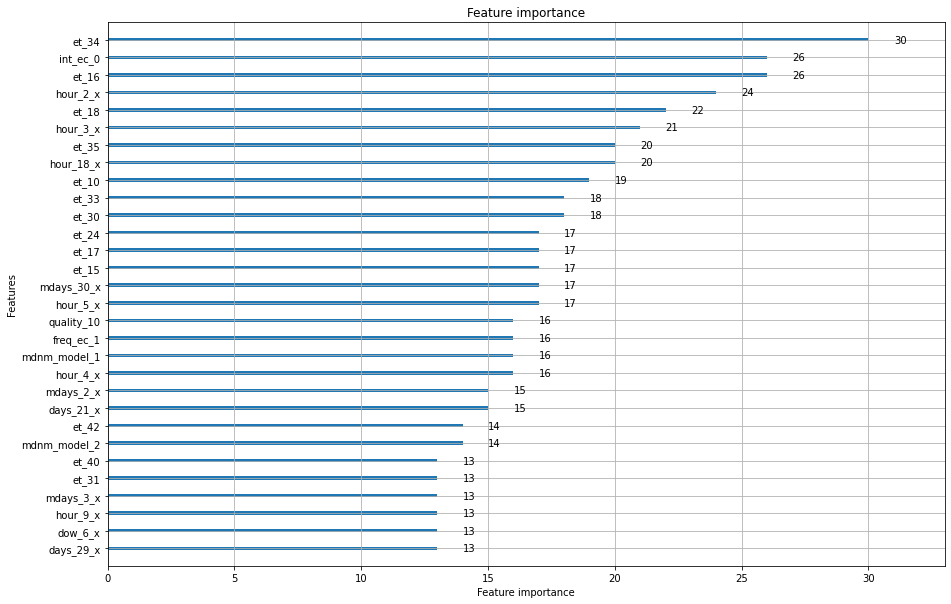

In [62]:
%%time
lgb_model = lgb.LGBMClassifier( n_estimators=100,
                               bagging_fraction = 0.9,
                               feature_fraction = 0.2,
                               num_leaves=16,
                               n_jobs = -1,
                               random_state=5)
result = cross_val_score(cv=5, estimator=lgb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

X_train, X_val, y_train, y_val= train_test_split(train[X], train[y], test_size=0.33, random_state=42)
lgb_model.fit(X_train, y_train)
pred = lgb_model.predict_proba(X_val)[:,1]
lgb.plot_importance(lgb_model, max_num_features=30, figsize=(15,10))
pd.crosstab(np.where(y_val>1, 1, y_val), np.where(pred>0.5, 1, 0))


## 0.81531085
##0.8175844

[09:58:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

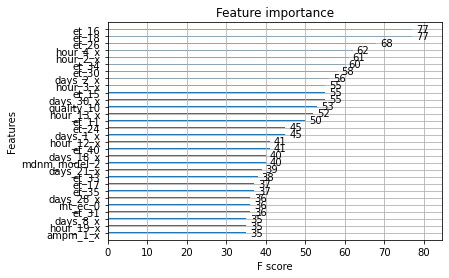

In [88]:
# 이거 오래걸림

#%%time
xgb_model = xgb.XGBClassifier(colsample_bytree=0.7,
                          learning_rate=0.05, 
                          max_depth=4, 
                          n_estimators=300,
                          subsample=0.9,
                          random_state =7, 
                          nthread = -1)
result = cross_val_score(cv=5, estimator=xgb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))
xgb_model.fit(train[X], train[y])
xgb.plot_importance(xgb_model, max_num_features=30)

#0.8145358499999998

In [89]:
%%time
gb_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=30, min_samples_split=10, 
                                   loss='deviance', random_state =5)
result = cross_val_score(cv=5, estimator=gb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

# 0.8186388000000001
# 

0.817128
CPU times: user 1min 6s, sys: 4.58 ms, total: 1min 6s
Wall time: 1min 6s


In [90]:
# 트레인 데이터로 모델 피팅

lgb_model.fit(train[X].values, train[y].values)
xgb_model.fit(train[X].values, train[y].values)
gb_model.fit(train[X].values, train[y].values)
# rf_model.fit(train[X].values, train[y].values)

#del train_qual

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[10:02:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features='sqrt',
                           min_samples_leaf=30, min_samples_split=10,
                           n_estimators=400, random_state=5)

In [95]:
train.columns.tolist()

['user_id',
 'Month_10_x',
 'Month_11_x',
 'Month_12',
 'days_1_x',
 'days_2_x',
 'days_3_x',
 'days_4_x',
 'days_5_x',
 'days_6_x',
 'days_7_x',
 'days_8_x',
 'days_9_x',
 'days_10_x',
 'days_11_x',
 'days_12_x',
 'days_13_x',
 'days_14_x',
 'days_15_x',
 'days_16_x',
 'days_17_x',
 'days_18_x',
 'days_19_x',
 'days_20_x',
 'days_21_x',
 'days_22_x',
 'days_23_x',
 'days_24_x',
 'days_25_x',
 'days_26_x',
 'days_27_x',
 'days_28_x',
 'days_29_x',
 'days_30_x',
 'days_31_x',
 'dow_0_x',
 'dow_1_x',
 'dow_2_x',
 'dow_3_x',
 'dow_4_x',
 'dow_5_x',
 'dow_6_x',
 'hour_0_x',
 'hour_1_x',
 'hour_2_x',
 'hour_3_x',
 'hour_4_x',
 'hour_5_x',
 'hour_6_x',
 'hour_7_x',
 'hour_8_x',
 'hour_9_x',
 'hour_10_x',
 'hour_11_x',
 'hour_12_x',
 'hour_13_x',
 'hour_14_x',
 'hour_15_x',
 'hour_16_x',
 'hour_17_x',
 'hour_18_x',
 'hour_19_x',
 'hour_20_x',
 'hour_21_x',
 'hour_22_x',
 'hour_23_x',
 'wd_0_x',
 'wd_1_x',
 'ampm_0_x',
 'ampm_1_x',
 'mdays_0_x',
 'mdays_1_x',
 'mdays_2_x',
 'mdays_3_x',
 'mday

In [94]:
test.columns.tolist()

['user_id',
 'Month_10',
 'Month_11',
 'Month_12',
 'days_1',
 'days_2',
 'days_3',
 'days_4',
 'days_5',
 'days_6',
 'days_7',
 'days_8',
 'days_9',
 'days_10',
 'days_11',
 'days_12',
 'days_13',
 'days_14',
 'days_15',
 'days_16',
 'days_17',
 'days_18',
 'days_19',
 'days_20',
 'days_21',
 'days_22',
 'days_23',
 'days_24',
 'days_25',
 'days_26',
 'days_27',
 'days_28',
 'days_29',
 'days_30',
 'days_31',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'wd_0',
 'wd_1',
 'ampm_0',
 'ampm_1',
 'mdays_0',
 'mdays_1',
 'mdays_2',
 'mdays_3',
 'mdays_4',
 'mdays_5',
 'mdays_6',
 'mdays_7',
 'mdays_8',
 'mdays_9',
 'mdays_10',
 'mdays_11',
 'mdays_12',
 'mdays_13',
 'mdays_14',
 'mdays_15',


In [ ]:
# 테스트데이터로 예측

pred_lgb = lgb_model.predict_proba(test[X].values)[:,1]
pred_xgb = xgb_model.predict_proba(test[X].values)[:,1]
pred_gb = gb_model.predict_proba(test[X].values)[:,1]

In [ ]:
pred = pred_lgb*0.34 + pred_xgb*0.33 + pred_gb*0.33
test['pred_lgb'] = pred_lgb
test['pred_xgb'] = pred_xgb
test['pred_gb'] = pred_gb
test['problem'] = pred

In [ ]:
sample_submission = sample_submission[['user_id']].merge(test[['user_id', 'problem', 'pred_lgb', 'pred_xgb', 'pred_gb']], how='left', on='user_id')
sample_submission.loc[sample_submission['user_id']==43262, 'problem'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_lgb'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_xgb'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_gb'] = 0.5
sample_submission.to_csv("submission_1_31.csv", index=False)

In [ ]:
# user_id와 problem 컬럼만 선택한 파일 -> 제출 형식 14999x2
sample_submission_lgb = sample_submission.iloc[:,:2]
sample_submission_lgb.to_csv("submission_2_1_2.csv", index=False)